# <center>Advanced Machine Learning. Homework #2</center>
Task text:
<br>
(ru) https://docs.google.com/document/d/1MapaSpMax0cEnnY2-QJ2XMgzVHpj_UrucJK-1r5FgA8/
<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%%time
import os
path = os.getcwd() + '/drive/MyDrive/colab/'

data_results = pd.read_pickle(path + 'results.pkl')
data_players = pd.read_pickle(path + 'players.pkl')
data_tournaments = pd.read_pickle(path + 'tournaments.pkl')

CPU times: user 15.4 s, sys: 3.63 s, total: 19 s
Wall time: 21.5 s


Start with parsing data and splitting into train (2019) and test (2020) sets.

In [9]:
def parse_team_names(game_indices):
    team_id_name_mapping = {}
    for game_ix in tqdm(game_indices):
        for info in data_results[game_ix]:
            team_id = info['team']['id']
            team_name = info['team']['name']
            team_id_name_mapping[team_id] = team_name
    return team_id_name_mapping

tournaments_2019 = [k for k,v in data_tournaments.items() if v['dateStart'][:4] == '2019']
tournaments_2020 = [k for k,v in data_tournaments.items() if v['dateStart'][:4] == '2020']

games_2019 = []
games_2020 = []
for ix, info in data_results.items():
    try:
         if None not in [info_team['mask'] for info_team in info]:
            if ix in tournaments_2019:
                games_2019.append(ix)
            if ix in tournaments_2020:
                games_2020.append(ix)
    except KeyError:
        continue

data_tournaments_2019 = {ix: data_tournaments[ix]['name'] for ix in games_2019}
data_tournaments_2020 = {ix: data_tournaments[ix]['name'] for ix in games_2020}

len(games_2019), len(games_2020)

(678, 391)

In [10]:
player_id_name_mapping = {ix: f"{info['name']} {info['patronymic'] or ''} {info['surname']}" for ix, info in data_players.items()}
team_id_name_mapping = parse_team_names(games_2019 + games_2020)

Parsing data to DataFrame format.

In [7]:
def prepare_data(game_indices):
    data = []
    for game_ix in tqdm(game_indices):
        data_per_team = []
        n_teams = len(data_results[game_ix])
        if n_teams == 0:
            continue
        for info in data_results[game_ix]:
            team_id = info['team']['id']
            team_name = info['team']['name']
            answers_string = info['mask'].replace('X', '0').replace('?', '0')
            n_correct = info['questionsTotal']
            n_questions = len(answers_string)
            position = info['position']
            n_team_players = len(info['teamMembers'])
            for player in info['teamMembers']:
                player_id = player['player']['id']
                row = {'tournament_id': game_ix, 'n_teams': n_teams, 'team_id': team_id, 'n_questions': n_questions, 'n_correct': n_correct, 
                       'answers_string': answers_string, 'position': position, 'n_team_players': n_team_players, 'player_id': player_id}
                data_per_team.append(row)
        data_per_team = pd.DataFrame(data_per_team)
        n_questions = data_per_team['n_questions'].values
        if not np.all(n_questions == n_questions[0]):
            continue
        team_answers_df =  data_per_team[['team_id', 'answers_string']].drop_duplicates()
        team_answers_array = np.array([np.array([int(q_ans) for q_ans in ans]) for ans in team_answers_df['answers_string'].values])
        n_correct_answers_per_question = team_answers_array.sum(axis=0)
        team_single_answer = []
        for team_id, team_answers in zip(team_answers_df['team_id'].values, team_answers_array):
            for single_answer, n_correct, question_id in zip(team_answers, n_correct_answers_per_question, range(len(team_answers))):
                row = {'team_id': team_id, 'question_id': question_id, 'question_answer_rate': n_correct / n_teams, 'answer': single_answer}
                team_single_answer.append(row)
        team_single_answer = pd.DataFrame(team_single_answer)
        data_per_team_answer = pd.merge(data_per_team.drop(columns=['answers_string']), team_single_answer, on='team_id')
        del data_per_team, team_single_answer
        data.append(data_per_team_answer)
    data = pd.concat(data)
    gc.collect()
    return data

In [7]:
%%time
data_2019 = prepare_data(games_2019)


CPU times: user 25.5 s, sys: 1.88 s, total: 27.4 s
Wall time: 27.5 s


In [11]:
%%time
data_2020 = prepare_data(games_2020)


CPU times: user 8.82 s, sys: 323 ms, total: 9.14 s
Wall time: 9.2 s


In [9]:
data_2019

,tournament_id,n_teams,team_id,n_questions,n_correct,position,n_team_players,player_id,question_id,question_answer_rate,answer
0,4772,231,45556,36,28,1.0,6,6212,0,0.883117,1
1,4772,231,45556,36,28,1.0,6,6212,1,0.779221,1
2,4772,231,45556,36,28,1.0,6,6212,2,0.445887,1
3,4772,231,45556,36,28,1.0,6,6212,3,0.519481,1
4,4772,231,45556,36,28,1.0,6,6212,4,0.878788,1
...,...,...,...,...,...,...,...,...,...,...,...
4423,6191,22,76301,36,4,21.5,6,217859,31,0.000000,0
4424,6191,22,76301,36,4,21.5,6,217859,32,0.136364,0
4425,6191,22,76301,36,4,21.5,6,217859,33,0.818182,1
4426,6191,22,76301,36,4,21.5,6,217859,34,0.136364,0


## Part I: Logistic Regression

Let us gather data to classify whether a player with some characteristics would give correct answer to a question.
I propose using features
- player answer ratio - actually this metric effectively describes power of player
- average position of player in his team performance
- average number of players per team
- average number of teams per tournament
- question answer ratio - this may be used to induce hardness of question

In [10]:
def prepare_logreg_data(data, scaler=None, fit_scaler=None):
    data_ = data.copy()
    model_data = data.groupby('player_id')['answer'].mean().to_frame().reset_index().rename(columns={'answer': 'player_answer_rate'})
    df = data_[['player_id', 'position', 'n_teams']].drop_duplicates()
    df['normed_pos'] = df['position'] / df['n_teams']
    df = df.groupby('player_id')['normed_pos'].mean().to_frame().reset_index().rename(columns={'normed_pos': 'avg_normed_pos'})
    model_data = pd.merge(model_data, df, on='player_id')
    df = data_[['player_id', 'n_team_players']].drop_duplicates()
    df = df.groupby('player_id')['n_team_players'].mean().to_frame().reset_index().rename(columns={'n_team_players': 'avg_n_team_players'})
    model_data = pd.merge(model_data, df, on='player_id')
    df = data_[['player_id', 'n_teams']].drop_duplicates()
    df = df.groupby('player_id')['n_teams'].mean().to_frame().reset_index().rename(columns={'n_teams': 'avg_n_teams_per_tournament'})
    model_data = pd.merge(model_data, df, on='player_id')
    df = data_[['player_id', 'question_answer_rate', 'answer']]
    model_data = pd.merge(model_data, df, on='player_id')
    del data_, df
    if scaler is not None:
        if fit_scaler == True:
            model_data[['avg_n_team_players', 'avg_n_teams_per_tournament']] = scaler.fit_transform(model_data[['avg_n_team_players', 'avg_n_teams_per_tournament']])
        else:
            model_data[['avg_n_team_players', 'avg_n_teams_per_tournament']] = scaler.transform(model_data[['avg_n_team_players', 'avg_n_teams_per_tournament']])
        return model_data, scaler
    gc.collect()
    return model_data

In [11]:
%%time
scaler = MinMaxScaler()
logreg_data_2019, scaler = prepare_logreg_data(data_2019, scaler, fit_scaler=True)
logreg_data_2020, scaler = prepare_logreg_data(data_2020, scaler, fit_scaler=False)

CPU times: user 13.8 s, sys: 4.89 s, total: 18.7 s
Wall time: 18.8 s


In [12]:
logreg_data_2019

,player_id,player_answer_rate,avg_normed_pos,avg_n_team_players,avg_n_teams_per_tournament,question_answer_rate,answer
0,15,0.347193,0.717550,0.391304,0.208927,0.561831,1
1,15,0.347193,0.717550,0.391304,0.208927,0.803311,1
2,15,0.347193,0.717550,0.391304,0.208927,0.773126,1
3,15,0.347193,0.717550,0.391304,0.208927,0.539435,0
4,15,0.347193,0.717550,0.391304,0.208927,0.296981,0
...,...,...,...,...,...,...,...
16215174,224542,0.750000,0.159509,0.260870,0.131687,0.570552,1
16215175,224542,0.750000,0.159509,0.260870,0.131687,0.736196,1
16215176,224542,0.750000,0.159509,0.260870,0.131687,0.920245,1
16215177,224542,0.750000,0.159509,0.260870,0.131687,0.533742,1


In [13]:
%%time
X_train = logreg_data_2019.drop(columns=['player_id', 'answer']) 
y_train = logreg_data_2019['answer'].values
X_test = logreg_data_2020.drop(columns=['player_id', 'answer'])
y_test = logreg_data_2020['answer'].values

model = LogisticRegression()
model.fit(X_train, y_train)

CPU times: user 54.1 s, sys: 4.65 s, total: 58.7 s
Wall time: 48.3 s


### Check performance of baseline Logistic Regression

In [14]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.764902441101637, 0.7674482549139406)

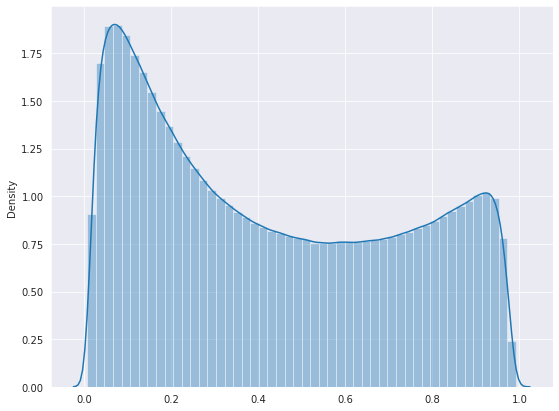

In [15]:
logreg_test_pred = model.predict_proba(X_train)[:, 1]

plt.figure(figsize=(9, 7))
sns.distplot(logreg_test_pred);

### Player rating and Team rating

I propose to define player rating/force as average predicted correct answer. 

Rating/force of team is defined as sum of player ratings/forces. I prefer summation over taking average because teams may have different number of players, and it is quite reasonable to assume that team with larger number of players has more power and more chance to answer correctly. 

In [19]:
logreg_data_2019['predicted_result'] = logreg_test_pred
player_rating = logreg_data_2019.groupby('player_id')['predicted_result'].mean().to_frame().reset_index().rename(columns={'predicted_result': 'player_rating'})
player_rating.head(3)

,player_id,player_rating
0,15,0.331520
1,16,0.529769
2,23,0.511464


In [20]:
test_results = pd.merge(data_2020[['tournament_id', 'team_id', 'n_correct', 'position', 'player_id']].drop_duplicates(), player_rating, on='player_id')
team_rating = test_results.groupby(['tournament_id', 'team_id'])['player_rating'].sum().to_frame().reset_index().rename(columns={'player_rating': 'team_rating'})
test_results = pd.merge(test_results[['tournament_id', 'team_id', 'n_correct', 'position']].drop_duplicates(), team_rating, on=['tournament_id', 'team_id'])
test_results

,tournament_id,team_id,n_correct,position,team_rating
0,4957,49804,26,1.0,4.364155
1,5414,46381,30,5.0,4.012876
2,5719,2865,27,24.0,3.246689
3,5730,49758,32,1.0,4.002477
4,5754,77648,28,53.5,2.745914
...,...,...,...,...,...
19269,6340,66688,11,18.0,0.969289
19270,6339,68242,6,28.0,0.856211
19271,6339,73580,5,29.5,0.653050
19272,6405,77431,23,6.0,0.446827


In [5]:
def correlation(test_results):
    """
    Calculates Kendall and Spearman correlation.
    Needs columns: "tournament_id", "n_correct", "team_rating"
    """
    kendall = np.array([])
    spearman = np.array([])
    for tournament_id in tqdm(test_results['tournament_id'].unique()):
        results_per_tournament = test_results[test_results['tournament_id'] == tournament_id]
        kendall_per_tour = stats.kendalltau(results_per_tournament['n_correct'], results_per_tournament['team_rating']).correlation
        spearman_per_tour = stats.spearmanr(results_per_tournament['n_correct'], results_per_tournament['team_rating']).correlation
        kendall = kendall if (np.isnan(kendall_per_tour) or (kendall_per_tour < 0.)) else np.append(kendall, kendall_per_tour)
        spearman = spearman if (np.isnan(spearman_per_tour) or (spearman_per_tour < 0.)) else np.append(spearman, spearman_per_tour)
    print(f"Average Kendall correlation: {np.mean(kendall)}")
    print(f"Average Spearman correlation: {np.mean(spearman)}")

Calculate correlation of true test results and evaluated team rating/force. 

In [23]:
correlation(test_results)


Average Kendall correlation: 0.5170208987823388
Average Spearman correlation: 0.6748708044305693


In [ ]:
del logreg_data_2019, logreg_data_2020
gc.collect()

0

## Part II: EM-algorithm

### Idea:
Let us consider result of one team in a tournament. We have an array of answers $(1,1,0,1,..).$ I propose to consider this result as mixture of performances of each player in command, applying that each player has his own *player_force*. It is convenient to operate with *player_force* as probability of correct answer $\rightarrow$ success/failure in Bernoulli experiment $(1, f)$, here $\ f$ - probability of success (~force of player).

So, for fixed $t \in \{1, \dots, T\}$ - number of all teams in dataset (unique team up to tournament) we consider Bernoulli mixture model:
$$
    p(x) = \sum_{k=1}^{K_t} \pi_k^t \ p(x, f_k^t),
$$
where 
$k \in \{1, ... K_t\}$ - index of player in group $t, \quad$
$\pi_k^t$ - weight of $k$-th player in team performance, $\quad$
$p(x, f_k^t) = (f_k^t)^x \ (1 - f_k^t)^{1-x} \ \sim Bi(1, f_k^t) -$ Bernoulli distribution responding to $k$-th player.

Also, for each fixed team result $t$ we consider mask of answers $\rightarrow x_1^t, \dots x_{N_t}^t, \ x_n^t$ equals to one or zero (correct/incorrect answer), $N_t - $ number of observations (questions) in each team data. Each of $x_n^t$ is a realisation of random variable $X$ with mixture distribution.

We deal with mixture of distributions, hence the usage of EM-algorithm for mixture decomposition would be quite useful. Now we introduce set of latent variables $\{Z_{nk}^t\}$ which indicate that result on $n$-th question was influenced by $k$-th player. Write down loglikelihood:
$$
    \log(L(X, Z)) = \sum_{n=1}^{N_t} \sum_{k=1}^{K_t} Z_{nk}^t [ \log(\pi_k^t) + \log(p(X_n^t, f_k^t))].
$$

<br>

The **EM-algorithm** runs as follows.

First we start from some initial player weights and player forces. I propose to use (upper index $t$ was omitted not to overload formulas):
$$
    \pi_k^{(0)} = \dfrac{1}{K}, \ f_k^{(0)} = \dfrac{1}{N} \sum_{n=1}^N x_n.
$$


**E-step:** Calculate expectation of loglikelihood under condition of data $X$:

$$
    \mathbb{E} Z_{nk} = \dfrac{\pi_k \ p(x_n, f_k)}{\sum_{j=1}^K \pi_j \ p(x_n, f_j)}.
$$ 

**M-step:** Maximize loglikelihood with respect to parameters $\pi, f$. In this form it is easy to calculate gradients, let us set them to zero and derive formulas for updating parameters:

$$
    \pi_k = \dfrac{1}{N} \sum_{n=1}^N \mathbb{E} z_{nk}, \\
    f_k = \dfrac{\sum_{n=1}^N \mathbb{E} z_{nk} \ x_n}{\sum_{n=1}^N \mathbb{E} z_{nk}}.
$$

So, the procedure is ready :)

<br>

**Final action:** By now we considered each team independently, all solutions above are correct up to team index $t$, so the algorithm updates <u>weights of player in team</u> and <u>force of player in team</u>. But we know that any player may take part in different tournaments in different teams, thus all we need to do is to aggregate player forces (via taking average) among all player performances in different teams. Now an iteration is completed.


<br>

Notes on implementation:
- $x_n$ in our case equal to either one or zero, hence calculation of density is very simple: $\ p(x, f) = f \ \mathbb{1}[x=1] + (1 - f) \mathbb{1}[x=0]$
- variables in code: $\ \mathbb{E}z$ - *latent*, $\ \pi$ - *player_team_weight*, $\ f$ - *player_force*.

In [12]:
def prepare_EM_data(data):
    df_team_tour_id = data[['tournament_id', 'team_id']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'team_tour_id'})
    data = pd.merge(data, df_team_tour_id, on=['tournament_id', 'team_id']).drop(columns=['tournament_id', 'team_id'])

    # add initial parameters for EM-algorithm
    data['player_team_weight'] = 1. / data['n_team_players']
    data['player_force'] = data['n_correct'] / data['n_questions']
    
    data = data[['team_tour_id', 'question_id', 'player_id', 'answer', 'player_team_weight', 'player_force']].sort_values(['team_tour_id', 'question_id'])
    return data

In [13]:
def em_process(team_data):
    K = team_data['player_id'].nunique()
    N = team_data['question_id'].nunique()

    x, pi, f = team_data['answer'].values, team_data['player_team_weight'].values, team_data['player_force'].values

    # E-step: calculate expectations of latent variables
    z = pi * (x * f + (1. - x) * (1. - f))
    z = z.reshape(N, K) / z.reshape(N, K).sum(axis=1)[:, None]
    z = z.reshape(-1)
    
    # M-step: update weights (pi = player_team_weight) and player parameters (f = player_force)
    pi = z.reshape(N, K).mean(axis=0)
    f = (x * z).reshape(N, K).sum(axis=0) / z.reshape(N, K).sum(axis=0)
    
    team_data['latent'] = z
    team_data['player_team_weight'] = np.tile(pi, N)
    team_data['player_force'] = np.tile(f, N)
    return team_data


def EM(data, n_iterations):
    data = data.copy()
    for _ in tqdm(range(n_iterations)):
        
        # Run EM-algorithm for each team independently
        data = data.groupby('team_tour_id').apply(em_process)
        
        # update player_force from all his/hers performances in different teams
        player_to_force = data[['player_id', 'player_force', 'team_tour_id']].groupby('player_id')['player_force'].mean().to_dict()
        data['player_force'] = data['player_id'].map(player_to_force)

    player_force = data[['player_id', 'player_force']].drop_duplicates()
    return data, player_force

In [14]:
%%time
em_data_2019 = prepare_data(games_2019)
em_data_2019 = prepare_EM_data(em_data_2019)


CPU times: user 32.9 s, sys: 6.98 s, total: 39.9 s
Wall time: 40 s


In [15]:
em_data_2019

,team_tour_id,question_id,player_id,answer,player_team_weight,player_force
0,0,0,6212,1,0.166667,0.777778
36,0,0,18332,1,0.166667,0.777778
72,0,0,18036,1,0.166667,0.777778
108,0,0,22799,1,0.166667,0.777778
144,0,0,15456,1,0.166667,0.777778
...,...,...,...,...,...,...
16215034,78314,35,217855,0,0.166667,0.111111
16215070,78314,35,217856,0,0.166667,0.111111
16215106,78314,35,217857,0,0.166667,0.111111
16215142,78314,35,217858,0,0.166667,0.111111


### Run EM-algorithm end check its performance (10 iterations on data of year 2020):

In [16]:
%%time
em_results_2019, player_force_em = EM(em_data_2019, n_iterations=10)


CPU times: user 14min 31s, sys: 27.5 s, total: 14min 59s
Wall time: 14min 31s


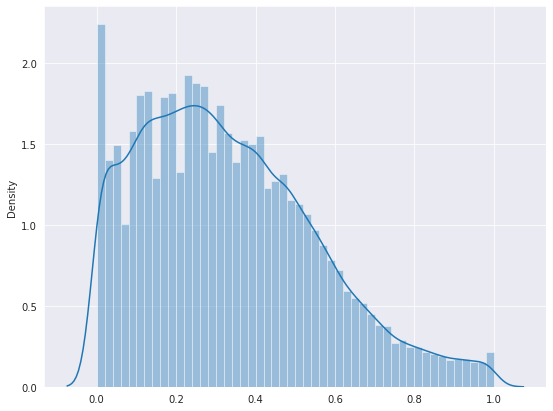

In [17]:
plt.figure(figsize=(9, 7))
sns.distplot(player_force_em['player_force'].values);

In [18]:
em_results_2019[em_results_2019['team_tour_id'].isin([0, 100, 200])][['team_tour_id', 'player_team_weight', 'player_force']].drop_duplicates()

,team_tour_id,player_team_weight,player_force
0,0,0.194014,0.857157
36,0,0.205435,0.882970
72,0,0.188751,0.818758
108,0,0.120762,0.488943
144,0,0.113048,0.470972
180,0,0.177990,0.763644
20052,100,0.170436,0.478889
20088,100,0.174685,0.411871
20124,100,0.166936,0.509131
20160,100,0.168261,0.506506


Interesting feature of EM-algorithm may be observed above: *player_force* and *player_team_weight* are correlated, but in some cases players with higher force have higher weight in team (*team_tour_id=0*), in some cases the situation is opposite (*team_tour_id=200*). 
This depend on team overall performance: in the table below we see that *team_tour_id=0* has higher *correct_answer_rate*, thus players with higher force from this team are more influencial. 

In [19]:
em_results_2019[em_results_2019['team_tour_id'].isin([0, 100, 200])].groupby('team_tour_id')['answer'].mean().to_frame().reset_index().rename(columns={'answer': 'correct_answer_rate'})

,team_tour_id,correct_answer_rate
0,0,0.777778
1,100,0.500000
2,200,0.305556


In [41]:
test_results_em = pd.merge(data_2020[['tournament_id', 'team_id', 'n_correct', 'position', 'player_id']].drop_duplicates(), player_force_em, on='player_id', how='left')
team_rating_em = test_results_em.groupby(['tournament_id', 'team_id'])['player_force'].sum().to_frame().reset_index().rename(columns={'player_force': 'team_rating'})
test_results_em = pd.merge(test_results_em[['tournament_id', 'team_id', 'n_correct', 'position']].drop_duplicates(), team_rating_em, on=['tournament_id', 'team_id'])
test_results_em

,tournament_id,team_id,n_correct,position,team_rating
0,4957,49804,26,1.0,4.831023
1,4957,4109,24,2.0,3.975480
2,4957,3875,23,3.0,3.569934
3,4957,77418,22,4.0,3.935055
4,4957,2,21,5.5,4.292963
...,...,...,...,...,...
19871,6456,55612,20,3.0,2.327324
19872,6456,68457,19,4.5,0.623747
19873,6456,43261,19,4.5,2.327071
19874,6456,69918,16,6.0,2.766766


Pretty well correlation metrics)

In [42]:
%%time
correlation(test_results_em)


Average Kendall correlation: 0.5246488305166097
Average Spearman correlation: 0.6833818795485416
CPU times: user 427 ms, sys: 14 ms, total: 441 ms
Wall time: 461 ms


### Tournament rating based on question complexity

On previous steps we calculated *question_answer_rate* as ratio of correct answers per given question. Let us now compose rating of tournaments as average question complexity that is refered based on *question_answer_rate*.

In [ ]:
tournament_rating = data_2019[['tournament_id', 'question_id', 'question_answer_rate']].drop_duplicates()
tournament_rating = tournament_rating.groupby('tournament_id')['question_answer_rate'].mean().to_frame().reset_index(b).rename(columns={'question_answer_rate': 'tournament_rating'})
tournament_rating.head(3)

,tournament_id,tournament_rating
0,4772,0.466330
1,4973,0.468409
2,4974,0.462323


In [ ]:
tournament_rating['tournament_name'] = tournament_rating['tournament_id'].map(data_tournaments_2019)
tournament_rating = tournament_rating.sort_values('tournament_rating')
tournament_rating

,tournament_id,tournament_rating,tournament_name
652,6149,0.000000,Чемпионат Санкт-Петербурга. Первая лига
382,5717,0.090598,Чемпионат Таджикистана
289,5599,0.155952,Чемпионат Туркменистана
568,5976,0.164352,Открытый Студенческий чемпионат Краснодарского...
656,6161,0.176812,Студенческий чемпионат Тюменской области
...,...,...,...
244,5540,0.663580,Регулярный чемпионат МГУ. Высшая лига. Третий ...
390,5726,0.683692,Первый турнир имени Джоуи Триббиани
560,5963,0.740741,Асинхрон по South Park
590,6003,0.745885,Второй тематический турнир имени Джоуи Триббиани


Note: *tournament_rating* $\in [0, 1]$, the lower rating is - the fewer number of correct answers per tournament - the harder is the tournament.